<a href="https://colab.research.google.com/github/xkzy/nlp_class_contest/blob/main/cmu-nlp-contest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!wget -nc https://github.com/xkzy/nlp_class_contest/releases/download/Dataset/input.txt
!wget -nc https://github.com/xkzy/nlp_class_contest/releases/download/Dataset/ans.txt
!wget -nc https://github.com/xkzy/nlp_class_contest/releases/download/Dataset/text_pairs.json
!wget -nc https://github.com/xkzy/nlp_class_contest/releases/download/keras_model/transformer_model_best_val.h5

File ‘input.txt’ already there; not retrieving.

File ‘ans.txt’ already there; not retrieving.

File ‘text_pairs.json’ already there; not retrieving.

File ‘transformer_model_best_val.h5’ already there; not retrieving.



In [8]:
!pip install deepcut -q -q -q --exists-action i
!pip install pythainlp['full'] -q -q -q --exists-action i

In [9]:
import subprocess
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import csv
import numpy as np
import deepcut
from keras.models import Model, load_model
from keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical, set_random_seed
import matplotlib.pyplot as plt
from random import shuffle
import pathlib
import random
import string
import re
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import pythainlp
import json
import os
from posixpath import split


set_random_seed(99)
random.seed(99)

In [10]:
try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

Nvidia GPU detected!


In [11]:
print(tf.__version__)
tf.test.is_gpu_available()
print(tf.config.list_physical_devices())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
def sentence_loader(input_file):
    out=[]
    for i in list(input_file):
        s = i.split('::')[1].strip()
        s = ' '.join(pythainlp.word_tokenize(s,engine = 'deepcut'))
        out.append(s)
    return out

def answer_loader(ans_file):
    out=[]
    for i in ans_file:
        sl=i.split('::')[1].strip().split(',')
        pad = (' [pad]'*(3-len(sl)))
        s = '[start] '+' '.join(sl)+' [end]'+pad
        out.append(s)
        print(s)
    return out

def pair_gen(s,a):
    return list(zip(s,a))

In [13]:
use_pre_cut_pair=True

text_pairs = []
if use_pre_cut_pair:
    with open('text_pairs.json', 'rb') as fp:
        text_pairs = json.load(fp)
else:
    with open('input.txt', 'r',encoding = 'utf-8-sig') as input_file:
        input_data = sentence_loader(input_file)
    with open('ans.txt', 'r',encoding = 'utf-8-sig') as ans_file:
        ans_data = answer_loader(ans_file)
    text_pairs = pair_gen(input_data,ans_data)
    with open("text_pairs.json", "w") as fp:
        json.dump(text_pairs, fp)
        print("Done writing JSON data into .json file")

In [14]:
print(len(text_pairs))
for _ in range(5):
    print(random.choice(text_pairs))

4818
['แม่ ตา มา หา   แล้ว ตา ก็ ลุก ไม่ ไหว', '[start] P P [end] [pad]']
['หลวงตาใส่ แว่น ตา สี ดำ แบรนด์ เนม คน นั้น แหละ ที่ ตก เป็น ข่าว อยู่ ตอน นี้', '[start] P E [end] [pad]']
['เพราะ อาการ สาย ตา ยาว ของ คุณ ตา จึง ทำ ให้ อ่าน หนังสือ ลำบาก', '[start] E P [end] [pad]']
['คง ต้อง ใช้ น้ำ ตา มากมาย เพื่อ ล้าง ตา   ไม่ ให้ เหลือ ภาพ เธอ ให้ จำ', '[start] E E [end] [pad]']
['ตา เป็น สามี ของ ยาย', '[start] P [end] [pad] [pad]']


In [15]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

4818 total pairs
3374 training pairs
722 validation pairs
722 test pairs


In [16]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_input_size = 5000
vocab_ans_size = 8
sequence_length = 100
sequence_ans_length = 5
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


input_vectorization = TextVectorization(
    max_tokens=vocab_input_size,
    # output_mode="tf_idf",
    output_mode="int",
    output_sequence_length=sequence_length,
    split='whitespace',
)
ans_vectorization = TextVectorization(
    max_tokens=vocab_ans_size,
    output_mode="int",
    output_sequence_length=sequence_ans_length + 1,
    standardize=custom_standardization,
    split='whitespace',
)
train_input_texts = [pair[0] for pair in train_pairs]
train_ans_texts = [pair[1] for pair in train_pairs]
input_vectorization.adapt(train_input_texts)
ans_vectorization.adapt(train_ans_texts)

In [17]:
len(input_vectorization.get_vocabulary())

3490

In [18]:
ans_vectorization.get_vocabulary()

['', '[UNK]', '[pad]', '[start]', '[end]', 'e', 'p', 't']

In [19]:
def format_dataset(input, ans):
    input = input_vectorization(input)
    ans = ans_vectorization(ans)
    return (
        {
            "encoder_inputs": input,
            "decoder_inputs": ans[:, :-1],
        },
        ans[:, 1:],
    )


def make_dataset(pairs):
    input_texts, ans_texts = zip(*pairs)
    input_texts = list(input_texts)
    ans_texts = list(ans_texts)
    dataset = tf.data.Dataset.from_tensor_slices((input_texts, ans_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
test_ds = make_dataset(test_pairs)

In [20]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 100)
inputs["decoder_inputs"].shape: (64, 5)
targets.shape: (64, 5)


In [21]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        attention_output = self.attention(query=inputs, value=inputs, key=inputs)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.add = layers.Add()  # instead of `+` to preserve mask
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, use_causal_mask=True
        )
        out_1 = self.layernorm_1(self.add([inputs, attention_output_1]))

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
        )
        out_2 = self.layernorm_2(self.add([out_1, attention_output_2]))

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(self.add([out_2, proj_output]))


    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [22]:
embed_dim = 300
latent_dim = 2048
num_heads = 16
num_en_transformer_blocks = 1
num_de_transformer_blocks = 1

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_input_size, embed_dim)(encoder_inputs)
for _ in range(num_en_transformer_blocks):
    x = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)

encoder_outputs = x
encoder = keras.Model(encoder_inputs, encoder_outputs,name="encoder")

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_ans_length, vocab_input_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
for _ in range(num_de_transformer_blocks-1):
    x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x,x)
    x = layers.Dropout(0)(x)
decoder_outputs = layers.Dense(vocab_ans_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs, name="decoder")

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [23]:
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding_1 (Po  (None, None, 300)            1501500   ['decoder_inputs[0][0]']      
 sitionalEmbedding)                                                                               
                                                                                                  
 decoder_state_inputs (Inpu  [(None, None, 300)]          0         []                            
 tLayer)                                                                                    

In [24]:
checkpoint = ModelCheckpoint('transformer_model_best_val.h5', #อย่าลืมเปลี่ยน path ให้ file
                             verbose=1,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max')

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding (Posi  (None, None, 300)            1530000   ['encoder_inputs[0][0]']      
 tionalEmbedding)                                                                                 
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                      

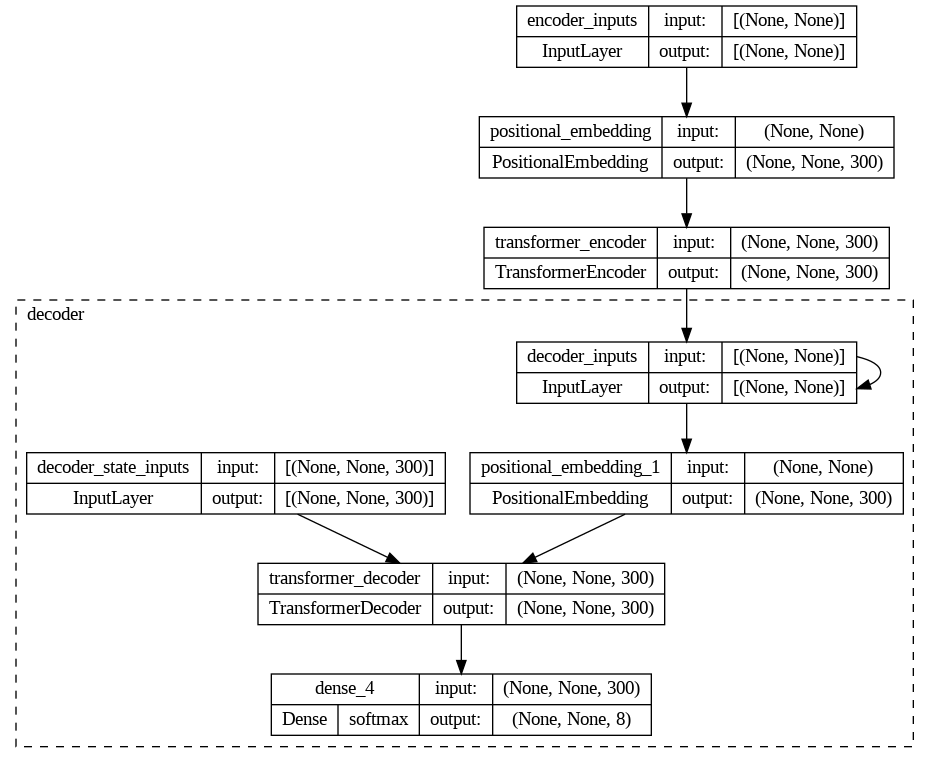

In [25]:
tf.keras.utils.plot_model(transformer,
                          to_file='transformer.png',
                          show_shapes=True,
                          expand_nested=True,
                          show_layer_names=True,
                          show_layer_activations=True,
                          show_trainable=False)

In [26]:
force_train = False
epochs = 300  # This should be at least 30 for convergence
if not os.path.exists('transformer_model_best_val.h5') or force_train:
    transformer.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=[checkpoint])

In [27]:
transformer = load_model('transformer_model_best_val.h5',custom_objects={
    'PositionalEmbedding': PositionalEmbedding,
    'TransformerDecoder': TransformerDecoder,
    'TransformerEncoder': TransformerEncoder,})

ans_vocab = ans_vectorization.get_vocabulary()
ans_index_lookup = dict(zip(range(len(ans_vocab)), ans_vocab))
max_decoded_sentence_length = sequence_ans_length


def decode_sequence(input_sentence):
    tokenized_input_sentence = input_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ans_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
        # print(predictions)
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ans_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
        # else:
        #     decoded_sentence += " " + sampled_token
    # return decoded_sentence[8:].strip().upper().replace(' ',',')
    return decoded_sentence.replace(" ", ",").replace("[start]", "").replace("[end]", "").upper().strip().strip(',')


In [28]:
test_input_texts = [pair[0] for pair in test_pairs]
test_ans_texts = [pair[1] for pair in test_pairs]

for _ in range(30):
    input_sentence,ans = random.choice(test_pairs)
    print(input_sentence)
    translated = decode_sequence(input_sentence)
    print(translated.replace(",", ""))
    print(ans.replace(" ", "").replace("[pad]", "").replace("[start]", "").replace("[end]", "").upper().strip().strip(','))

ฉัน เขียน ดาต้า เซท ไป เยอะ มาก ทั้ง ที่ ตา จะ ปิด   สุด ยอด มาก เลย
E
E
ตา นี้ ฉัน จะ เล่น กับ ตา
TT
TP
ตา เค้า เล่น แล้ว ห้าม แย่ง สิเทอ
T
T
คน ยุโรป ส่วน ใหญ่ มี ปัญหา เกี่ยว กับ การ รับ แสง ของ ดวง ตา มาก กว่า ชาว เอเชีย เนื่อง จาก มี สี ของ ดวง ตา ที่ อ่อน กว่า
EE
EE
ตา ของ แฟน ฉัน มี สี น้ำตาล
E
P
ตา เธอ สวย มาก เลย   จน ฉัน อยาก ได้ ตา ของ เธอ มา เป็น ของ ฉัน เลย
EE
EE
ตา มี ขาย หอย ยาย มอย ขาย สี
P
P
ตา เชียร์ ทีม   chicago   bull   เพราะ ตา ชอบ   micheal   jordan
PE
PP
เมื่อ โป เก ม่อน ใช้ ท่า ต่อสู้ ใน ตา นี้ แล้ว   ใน ตา ถัด ไป จะ ไม่ ได้ สามารถ ใช้ ท่า ต่อ สู่ นี้ ได้ อีก
TT
TT
โอดิน ได้ เสียสละ ตา ไป หนึ่ง ข้าง เพื่อ ความ รู้ ทุก อย่าง ส่วน อีก ตา ยัง เหลือ ไว้
PE
EE
ตอน นี้ ฉัน รู้สึก ง่วง จน ตา จะ ปิด
E
E
งั้น ก็ ถึง ตา ที่ ฉัน จะ ร้องเรียน ผู้ อำนวย การ แล้ว ล่ะ ถ้า งั้น
T
T
ตา ของ เขา เป็น คน ออก ค่า ใช้จ่าย ทุก อย่าง ตอน เขา ผ่าตัดตา และ รักษา ตัว
E
PE
ผม ต่อ คิว ก่อน   ต้อง ถึง ตาผม ก่อน สิ
T
T
ตาทิพย์ กลับ มา จาก ตลาด หรือ ยัง ครับ
P
P
ยาย   ตา ไป ไหน อ่ะ
P
P
ตา ฉัน

In [29]:
transformer.evaluate(test_ds, verbose=1)

12/12 [==============================] - 3s 69ms/step - loss: 0.3113 - accuracy: 0.8997


[0.3112967610359192, 0.8996952176094055]

In [30]:
def file_pred(inpfile,ansfile="my_ans.txt",writeout=True):
    out=[]
    with open(inpfile, 'r',encoding = 'utf-8-sig') as i_file:
        for i in list(i_file):
            c=0
            i_s=i.split('::')
            s = i_s[1].strip()
            token=pythainlp.word_tokenize(s,engine = 'deepcut')
            for k in token:
                if 'ตา' in k:
                    c+=1
            s = ' '.join(token)
            a=decode_sequence(s)
            al=a.split(',')
            if len(al)>c:
                al=al[:c]
                print('trimed output length')
            a=','.join(al)
            out.append(i_s[0]+'::'+a)
    if writeout:
        with open(ansfile, 'w', encoding='utf-8-sig') as o_file:
            o_file.write('\n'.join(out))
    return out

In [31]:
!mkdir -p /content/eval_test_set
%cd /content/eval_test_set
from google.colab import files
uploaded = files.upload()
t=file_pred(next(iter(uploaded)),'ans.txt')
print(t)
files.download('ans.txt')

/content/eval_test_set


Saving input_k.txt to input_k.txt
1/1 [==============================] - 0s 286ms/step
['1::E,E', '2::T,T', '3::P,E,P', '4::P,E,P', '5::P,E', '6::P,E', '7::E', '8::P', '9::P', '10::E', '11::E', '12::E', '13::E', '14::E', '15::E', '16::P', '17::P', '18::P', '19::P', '20::P', '21::P', '22::P', '23::P,T,P', '24::P,T,P', '25::P,P', '26::T,T', '27::T,T', '28::T', '29::P,P', '30::P,E']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>